In [1]:
import glob
import os
import numpy as np
import pandas as pd
import open3d as o3d
from matplotlib import pyplot as plt
from shapely.geometry import MultiLineString, Point, LineString
from shapely.ops import unary_union, polygonize
import scipy
from scipy.spatial import Delaunay, ConvexHull, distance_matrix
from collections import Counter
import itertools
import time
import cv2
import copy
import utils
import skimage
import enum
# import matlab.engine

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# MAT_ENGINE = matlab.engine.start_matlab()

In [3]:
SSM_DIR = r"./data/cpdAlignedData/eigValVec/"
NAME_IDX_MAP_CSV = r"./dataWithPhoto/nameIndexMapping.csv"
EDGE_MASK_PATH = r"./dataWithPhoto/normal_mask/"
NUM_PC = 20
SHIFT_VEC = np.array([0.,10.,0.])
PG_NPY = os.path.join("res-2D-3D", "Y_pg.npy")
MASK_NPY = os.path.join("res-2D-3D", "X_mask.npy")
PARAM_DIR = r"./data/params/"
UPPER_INDICES = [11,12,13,14,15,16,17,21,22,23,24,25,26,27] #不考虑智齿18,28
LOWER_INDICES = [31,32,33,34,35,36,37,41,42,43,44,45,46,47] #不考虑智齿38,48

In [4]:
TagID = 63 # 47 #
name_idx_df = pd.read_csv(NAME_IDX_MAP_CSV)
photo_types = ["upperPhoto","lowerPhoto","leftPhoto","rightPhoto","frontalPhoto"]

In [7]:
def getEdgeMask(edge_mask_path, name_idx_df, TagID, photo_types, resized_width=800):
    photoFiles = name_idx_df.loc[name_idx_df["index"]==TagID, photo_types].values[0]
    edgeMaskFiles = [os.path.join(edge_mask_path, os.path.splitext(os.path.basename(pf))[0]+".png") for pf in photoFiles]
    print(edgeMaskFiles)
    edgeMasks = []
    for edgeMaskFile in edgeMaskFiles:
        edgeMask = skimage.io.imread(edgeMaskFile, as_gray=True)
        rescale = resized_width / edgeMask.shape[1]
        edgeMask = skimage.transform.rescale(edgeMask, rescale, anti_aliasing=True)
        thre = 0.5
        edgeMask[edgeMask<thre] = 0.
        edgeMask[edgeMask>=thre] = 1.
        # edgeMask = skimage.morphology.binary_erosion(edgeMask, footprint=skimage.morphology.disk(2))
        edgeMasks.append(edgeMask)
    return edgeMasks

In [215]:
edgeMasks = getEdgeMask(EDGE_MASK_PATH, name_idx_df, TagID, photo_types, resized_width=1440)

['./dataWithPhoto/normal_mask/安然_219474_上牙列.png', './dataWithPhoto/normal_mask/安然_219474_下牙列.png', './dataWithPhoto/normal_mask/安然_219474_左侧咬合.png', './dataWithPhoto/normal_mask/安然_219474_右侧咬合.png', './dataWithPhoto/normal_mask/安然_219474_正位像.png']


num of contour points in upperPhoto: 17420 
num of contour points in lowerPhoto: 18187 
num of contour points in leftPhoto: 20509 
num of contour points in rightPhoto: 23605 
num of contour points in frontalPhoto: 28706 


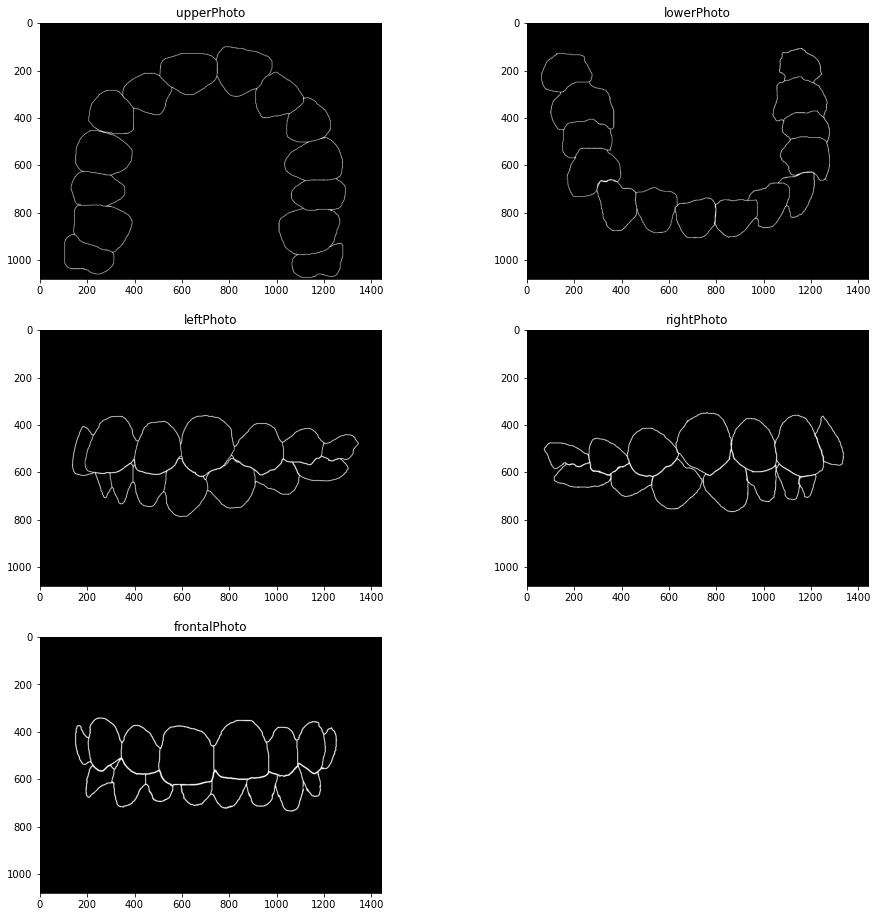

In [216]:
plt.figure(figsize=(16,16))
for i,ptype in enumerate(photo_types):
    plt.subplot(3,2,i+1)
    plt.imshow(edgeMasks[i], cmap='gray')
    plt.title(ptype)
    print("num of contour points in {}: {} ".format(ptype, np.sum(edgeMasks[i]>0)))

In [217]:
def GetPGByTagId(pg_npy, TagId):
    PGs = np.load(pg_npy)
    return PGs[TagId]

def GetMaskByTagId(mask_npy, TagId):
    Masks = np.load(mask_npy)
    return np.squeeze(Masks[TagId]) # shape=(28,)

def __getToothIndex(f):
    return int(os.path.basename(f).split(".")[0].split("_")[-1])

def loadMuEigValSigma(ssmDir, numPC=NUM_PC):
    """Mu.shape=(28,1500,3), sqrtEigVals.shape=(28,1,100), Sigma.shape=(28,4500,100)"""
    muNpys = glob.glob(os.path.join(ssmDir,"meanAlignedPG_*.npy"))
    muNpys = sorted(muNpys, key=lambda x:__getToothIndex(x))
    Mu = np.array([np.load(x) for x in muNpys])
    eigValNpys = glob.glob(os.path.join(ssmDir,"eigVal_*.npy"))
    eigValNpys = sorted(eigValNpys, key=lambda x:__getToothIndex(x))
    sqrtEigVals = np.sqrt(np.array([np.load(x) for x in eigValNpys]))
    eigVecNpys = glob.glob(os.path.join(ssmDir,"eigVec_*.npy"))
    eigVecNpys = sorted(eigVecNpys, key=lambda x:__getToothIndex(x))
    Sigma = np.array([np.load(x) for x in eigVecNpys])
    return Mu, sqrtEigVals[:,np.newaxis,:numPC], Sigma[...,:numPC]

def GetPgRefUL(PgRef, Mask, shiftVec):
    PG_U, PG_L = np.split(PgRef, 2, axis=0)
    PG_U = PG_U + shiftVec
    PG_L = PG_L - shiftVec
    Mask_U, Mask_L = np.split(Mask, 2, axis=0)
    return PG_U[Mask_U], PG_L[Mask_L]

In [218]:
Mu, SqrtEigVals, Sigma = loadMuEigValSigma(SSM_DIR, numPC=NUM_PC)
Mask = GetMaskByTagId(MASK_NPY, TagId=TagID)

In [219]:
# reference
PG_Ref = GetPGByTagId(PG_NPY, TagId=TagID)
X_Ref_U, X_Ref_L = GetPgRefUL(PG_Ref, Mask, SHIFT_VEC)

In [220]:
utils.showPointCloud(np.concatenate([X_Ref_U, X_Ref_L]).reshape(-1,3), "Reference PointCloud")

In [221]:
def loadInvRegistrationParams(loadDir):
    """生成DataFrame,含有逆配准参数s,R,transVec,transVecShift"""
    """initPG = np.multiply(s, np.matmul(PG+transVec, R)) + transVecShift"""
    toothIndices = UPPER_INDICES + LOWER_INDICES
    paramDF = pd.DataFrame(columns=["tag"])
    # 下牙列逆配准参数
    tags, rowScales, transVecShifts = utils.readToothRowScalesFromHDF5(os.path.join(loadDir, "scalesOfLowerToothRow.hdf5"), "L")
    indexTag = [int(tag[:-1]) for tag in tags]
    invScales = [1./s for s in rowScales]
    invTransVecShifts = -transVecShifts
    tempDF = pd.DataFrame({"tag":indexTag,"lower_s":list(invScales), "lower_ts":list(invTransVecShifts)})
    paramDF = paramDF.merge(tempDF, how="outer", on="tag")
    # 上牙列逆配准参数
    tags, rowScales, transVecShifts = utils.readToothRowScalesFromHDF5(os.path.join(loadDir, "scalesOfUpperToothRow.hdf5"), "U")
    indexTag = [int(tag[:-1]) for tag in tags]
    invScales = [1./s for s in rowScales]
    invTransVecShifts = -transVecShifts
    tempDF = pd.DataFrame({"tag":indexTag,"upper_s":list(invScales), "upper_ts":list(invTransVecShifts)})
    paramDF = paramDF.merge(tempDF, how="outer", on="tag")
    # 牙齿统计形状逆配准参数
    for i in toothIndices:
        h5File = os.path.join(loadDir, "sRtParams_{}.hdf5".format(i))
        tags, scales, rotMats, transVecs = utils.readRegistrationParamsFromHDF5(h5File, i)
        indexTag = [int(tag[:-1]) for tag in tags]
        invRotAngles = np.array([utils.rotationMatrixToEulerAngles(r.T) for r in rotMats])
        invScales = 1./scales
        invTransVecs = -transVecs
        tempDF = pd.DataFrame({"tag":indexTag,"{}s".format(i):list(invScales), "{}rx".format(i):list(invRotAngles[:,0]), \
                               "{}ry".format(i):list(invRotAngles[:,1]), "{}rz".format(i):list(invRotAngles[:,2]), \
                               "{}tx".format(i):list(invTransVecs[:,0]), "{}ty".format(i):list(invTransVecs[:,1]), \
                               "{}tz".format(i):list(invTransVecs[:,2])})
        paramDF = paramDF.merge(tempDF, how="outer", on="tag")
    sUpperColumns = ["{}s".format(id) for id in UPPER_INDICES]
    sLowerColumns = ["{}s".format(id) for id in LOWER_INDICES]
    paramDF = paramDF[~paramDF[sUpperColumns].isna().all(axis=1)]
    paramDF = paramDF[~paramDF[sLowerColumns].isna().all(axis=1)] # 删除缺少上牙列或下牙列的数据
    paramDF = paramDF.sort_values(by="tag", ignore_index=True)
    return paramDF

def getMeanAndVarianceOfInvRegistrationParams(invParamDF):
    invScalesColumns = ["{}s".format(id) for id in UPPER_INDICES+LOWER_INDICES]
    invRotAngleXYZColumns = ["{}r{}".format(id, p) for id in UPPER_INDICES+LOWER_INDICES for p in ["x","y","z"]]
    invTransVecXYZColumns = ["{}t{}".format(id, p) for id in UPPER_INDICES+LOWER_INDICES for p in ["x","y","z"]]
    invScales = invParamDF[invScalesColumns].to_numpy()
    invScaleMeans = np.nanmean(invScales, axis=0)
    invScaleVars = np.nanvar(invScales, ddof=1, axis=0)
    invRotAngleXYZs = invParamDF[invRotAngleXYZColumns].to_numpy()
    invRotAngleXYZMeans = np.nanmean(invRotAngleXYZs, axis=0)
    invRotAngleXYZVars = np.nanvar(invRotAngleXYZs, ddof=1, axis=0)
    invTransVecXYZs = invParamDF[invTransVecXYZColumns].to_numpy()
    invTransVecXYZMeans = np.nanmean(invTransVecXYZs, axis=0)
    invTransVecXYZVars = np.nanvar(invTransVecXYZs, ddof=1, axis=0)
    return invScaleMeans, invScaleVars, invRotAngleXYZMeans, invRotAngleXYZVars, invTransVecXYZMeans, invTransVecXYZVars
    

In [222]:
invRegistrationParamDF = loadInvRegistrationParams(loadDir=PARAM_DIR)

In [223]:
np.var(invRegistrationParamDF["upper_s"].to_numpy(),ddof=1)

0.002698920992637824

In [224]:
cols = ["{}s".format(id) for id in UPPER_INDICES+LOWER_INDICES]
cols = ["{}r{}".format(id, p) for id in UPPER_INDICES for p in ["x","y","z"]]
cols = ["{}r{}".format(id, p) for id in LOWER_INDICES for p in ["x","y","z"]]
cols = ["{}t{}".format(id, p) for id in UPPER_INDICES for p in ["x","y","z"]]
cols = ["{}t{}".format(id, p) for id in LOWER_INDICES for p in ["x","y","z"]]
A = invRegistrationParamDF[cols]
covA = np.ma.cov(np.ma.masked_invalid(A), rowvar=False)
assert not covA.mask.any() #检查是否有nan
covMat = covA.data
assert utils.is_pos_def(covMat)
# print(np.linalg.inv(covMat))
variances = np.ma.var(np.ma.masked_invalid(A), axis=0, ddof=1)
assert not variances.mask.any() #检查是否有nan
std = np.sqrt(variances.data)
rhoCoef = covMat / np.multiply(std[:,None],std)
print(rhoCoef)

[[ 1.         -0.08949067 -0.24436522 ... -0.21023079  0.0276052
   0.23469078]
 [-0.08949067  1.          0.22892103 ...  0.11827882  0.08660109
   0.03614325]
 [-0.24436522  0.22892103  1.         ... -0.007835   -0.17110924
  -0.43084098]
 ...
 [-0.21023079  0.11827882 -0.007835   ...  1.          0.18623064
  -0.28245196]
 [ 0.0276052   0.08660109 -0.17110924 ...  0.18623064  1.
   0.17232253]
 [ 0.23469078  0.03614325 -0.43084098 ... -0.28245196  0.17232253
   1.        ]]


In [225]:
invScaleMeans, invScaleVars, invRotAngleXYZMeans, invRotAngleXYZVars, invTransVecXYZMeans, invTransVecXYZVars = getMeanAndVarianceOfInvRegistrationParams(invRegistrationParamDF)

In [226]:
def GetCovMat(invParamDF, toothIndices):
    suffixes = ["s","rx","ry","rz","tx","ty","tz"]
    covMats = []
    for id in toothIndices:
        cols = [str(id)+suffix for suffix in suffixes]
        A = invParamDF[cols].to_numpy()
        covA = np.ma.cov(np.ma.masked_invalid(A), rowvar=False)
        assert not covA.mask.any() #检查是否有nan
        covMat = covA.data
        assert utils.is_pos_def(covMat)
        # variances = np.ma.var(np.ma.masked_invalid(A), axis=0, ddof=1)
        # assert not variances.mask.any() #检查是否有nan
        # std = np.sqrt(variances.data)
        # rhoCoef = covMat / np.multiply(std[:,None],std)
        # print(rhoCoef)
        covMats.append(covMat)
    return np.array(covMats,dtype=np.float32)

In [227]:
CovMats = GetCovMat(invRegistrationParamDF, toothIndices=UPPER_INDICES+LOWER_INDICES)

## Test Script

In [228]:
def ExtrinsicViewMatrix(rxyz, txyz): # world coord to camera coord
    # 先进行x轴旋转，再y轴，再z轴；取转置表示右乘旋转矩阵，再平移
    R = o3d.geometry.get_rotation_matrix_from_zyx(rxyz[::-1]).T
    return np.vstack([R,txyz]) # Matrix 4*3

def IntrinsicProjectionMatrix(f, dx, dy, u0, v0): # camera cood to image coord
    mat1 = np.diag([f, f, 1.])
    mat2 = np.array([[1./dx, 0., 0.], [0., 1./dy, 0.], [u0, v0, 1.]])
    return mat1 @ mat2 # Matrix 3*3

In [229]:
X = X_Ref_U
# rxyz = np.array([0.,0.95*np.pi,np.pi]) # frontal
rxyz = np.array([-0.3*np.pi, np.pi, np.pi]) # upper
# rxyz = np.array([0.0,0.7*np.pi,np.pi]) # left
# rxyz = np.array([0.0,-0.7*np.pi,np.pi]) # right
# txyz = np.array([-X[...,0].min(), -X[...,1].min(), -X[...,2].min()+130])
txyz = np.array([0.,0.,-X[...,2].min()+45.])

In [230]:
X[...,0].max()-X[...,0].min()

63.00180735555209

In [231]:
X[...,1].max()-X[...,1].min()

10.168440826398019

In [248]:
edgeMask = edgeMasks[0]
extrinsicMat = ExtrinsicViewMatrix(rxyz, txyz)
height, width = edgeMask.shape
intrinsicMat = IntrinsicProjectionMatrix(f=50, dx=0.04, dy=0.04, u0=width//2, v0=height//2)

In [249]:
def GetCameraCoordPointPos(X_world, extrinsicMat):
    # X_camera: 3D point cloud in camera coord, array shape (n,3) or (batch,n,3)
    # extrinsicMat: Matrix 3*4
    X_homo = np.concatenate([X_world, np.ones((*X_world.shape[:-1],1))], axis=-1)
    return np.matmul(X_homo, extrinsicMat)

def GetImageCoordPointPos(X_camera, intrinsicMat):
    # X_camera: 3D point cloud in camera coord, array shape (n,3) or (batch,n,3)
    # intrinsicMat: Matrix 3*3
    assert (X_camera[...,2]>0).all() # Z-value of points should be positive
    X_image = np.matmul((X_camera/X_camera[...,[2]]), intrinsicMat)
    X_uv = X_image[...,:2]
    return np.around(X_uv).astype(np.int32)

# def GetUniquePixels(X_uv):
#     # merge points at the same position in image coord
#     # X_uv: array shape (batch,n,2) dtype np.int32
#     # pixels: array (m,2), each element represents (u_x, v_y)
#     X_uv_int = X_uv.reshape(-1,2)
#     pixels = np.unique(X_uv_int,axis=0)
#     return pixels

def GetUniquePixels(X_uv):
    # merge points at the same position in image coord
    # X_uv: array shape (batch,n,2) dtype np.int32
    # pixels: array (m,2), each element represents (u_x, v_y)
    X_uv_int = X_uv.reshape(-1,2)
    pixels, unique_indices = np.unique(X_uv_int,axis=0,return_index=True)
    return pixels, unique_indices

# def GetVisiblePixels(X_uv, depth):
#     # 未考虑点云是离散的，后面的点也有可能是可视的
#     # X_uv: array shape (batch,n,2) dtype np.int32
#     # depth: array shape (batch, n)
#     idx = np.tile(np.arange(X_uv.shape[0])[:,np.newaxis], [1,X_uv.shape[1]])
#     X_uv_ensem = X_uv.reshape(-1,2)
#     df = pd.DataFrame({"pos_x":X_uv_ensem[:,0],"pos_y":X_uv_ensem[:,1],"tag":idx.flatten(),"depth":depth.flatten()})
#     idx = df.groupby(by=["pos_x","pos_y"],sort=False)["depth"].transform(min) == df["depth"]
#     df_vis = df[idx]
#     vis_pixels = []
#     for grp_idx in df_vis.groupby(by="tag",sort=False).groups.values():
#         vis_pixels.append(df.loc[grp_idx,["pos_x","pos_y"]].to_numpy())
#     return vis_pixels


# def GetPointsWithNormalsVeticalToAxisZ(X, eps):
#     # 未考虑边缘点之外的点也有可能与Z轴垂直
#     vertices = X.reshape(-1,3)
#     pcd = o3d.geometry.PointCloud()
#     pcd.points = o3d.utility.Vector3dVector(vertices)
#     pcd.estimate_normals()
#     # to obtain a consistent normal orientation
#     pcd.orient_normals_consistent_tangent_plane(k=15)
#     normals = np.asarray(pcd.normals)
#     return vertices[np.abs(normals[:,2])<eps]

# def concave_hull(coords, alpha):  # coords is a 2D numpy array
#     # i removed the Qbb option from the scipy defaults.
#     # it is much faster and equally precise without it.
#     # unless your coords are integers.
#     # see http://www.qhull.org/html/qh-optq.htm
#     tri = Delaunay(coords, qhull_options="Qc Qz Q12 Qbb").vertices
#     ia, ib, ic = (tri[:, 0], tri[:, 1], tri[:, 2])  # indices of each of the triangles' points
#     pa, pb, pc = (coords[ia], coords[ib], coords[ic])  # coordinates of each of the triangles' points
#     a = np.linalg.norm(pa-pb, ord=2, axis=1)
#     b = np.linalg.norm(pb-pc, ord=2, axis=1)
#     c = np.linalg.norm(pc-pa, ord=2, axis=1)
#     s = (a + b + c) * 0.5  # Semi-perimeter of triangle
#     area = np.sqrt(s * (s - a) * (s - b) * (s - c))  # Area of triangle by Heron's formula
#     filter = (a * b * c / (4.0 * area) < 1.0 / alpha)  # Radius Filter based on alpha value
#     # Filter the edges
#     edges = tri[filter]

#     # now a main difference with the aforementioned approaches is that we dont
#     # use a Set() because this eliminates duplicate edges. in the list below
#     # both (i, j) and (j, i) pairs are counted. The reasoning is that boundary
#     # edges appear only once while interior edges twice
#     edges = [tuple(sorted(combo)) for e in edges for combo in itertools.combinations(e, 2)]
#     # sorted_edges = np.sort(np.vstack([edges[:,[0,1]], edges[:,[0,2]], edges[:,[1,2]]]))
#     # edges = list(map(tuple, sorted_edges))

#     count = Counter(edges)  # count occurrences of each edge
#     # keep only edges that appear one time (concave hull edges)
#     edges = [e for e, c in count.items() if c == 1]
#     # these are the coordinates of the edges that comprise the concave hull
#     edges = [(coords[e[0]], coords[e[1]]) for e in edges]
#     # use this only if you need to return your hull points in "order" (i think its CCW)
#     ml = MultiLineString(edges)
#     poly = polygonize(ml)
#     hull = unary_union(list(poly))
#     hull_vertices = hull.exterior.coords.xy # the first vertex equals the last vertex
#     # edges may contain the line segments of the same line
#     return np.array(hull_vertices).T.astype(X_uv.dtype), hull

def concave_hull(coords, alpha, return_edges=False):  # coords is a 2D numpy array
    # i removed the Qbb option from the scipy defaults.
    # it is much faster and equally precise without it.
    # unless your coords are integers.
    # see http://www.qhull.org/html/qh-optq.htm
    tri = Delaunay(coords, qhull_options="Qt Qc Qz Q12").simplices
    ia, ib, ic = (tri[:, 0], tri[:, 1], tri[:, 2])  # indices of each of the triangles' points
    pa, pb, pc = (coords[ia], coords[ib], coords[ic])  # coordinates of each of the triangles' points
    a = np.linalg.norm(pa-pb, ord=2, axis=1)
    b = np.linalg.norm(pb-pc, ord=2, axis=1)
    c = np.linalg.norm(pc-pa, ord=2, axis=1)
    s = (a + b + c) * 0.5  # Semi-perimeter of triangle
    area = np.sqrt(s * (s - a) * (s - b) * (s - c))  # Area of triangle by Heron's formula
    filter = (a * b * c / (4.0 * area) < 1.0 / alpha)  # Radius Filter based on alpha value
    # Filter the edges
    edges = tri[filter]

    # now a main difference with the aforementioned approaches is that we dont
    # use a Set() because this eliminates duplicate edges. in the list below
    # both (i, j) and (j, i) pairs are counted. The reasoning is that boundary
    # edges appear only once while interior edges twice
    edges = [tuple(sorted(combo)) for e in edges for combo in itertools.combinations(e, 2)]
    # sorted_edges = np.sort(np.vstack([edges[:,[0,1]], edges[:,[0,2]], edges[:,[1,2]]]))
    # edges = list(map(tuple, sorted_edges))

    count = Counter(edges)  # count occurrences of each edge
    # keep only edges that appear one time (concave hull edges)
    edge_indices = [e for e, c in count.items() if c == 1]
    # these are the coordinates of the edges that comprise the concave hull
    edges = [(coords[e[0]], coords[e[1]]) for e in edge_indices]
    # use this only if you need to return your hull points in "order" (i think its CCW)
    ml = MultiLineString(edges)
    poly = polygonize(ml)
    hull = unary_union(list(poly))
    # hull_vertices = hull.exterior.coords.xy # the first vertex equals the last vertex
    # edges may contain the line segments of the same line
    if return_edges == True:
        return np.array(edge_indices), hull, edges
    else:
        return np.array(edge_indices), hull

def GetDepthMap(X_uv, depth):
    # X_uv: array shape (batch,n,2) dtype np.int32
    idx = np.tile(np.arange(X_uv.shape[0])[:,np.newaxis], [1,X_uv.shape[1]])
    X_uv_ensem = X_uv.reshape(-1,2)
    df = pd.DataFrame({"pos_x":X_uv_ensem[:,0],"pos_y":X_uv_ensem[:,1],"tag":idx.flatten(),"depth":depth.flatten()})
    idx = df.groupby(by=["tag", "pos_x","pos_y"],sort=False)["depth"].transform(min) == df["depth"]
    df_vis = df[idx]
    pos_idx = pd.MultiIndex.from_frame(df_vis[["tag","pos_x","pos_y"]])
    depth_map = pd.Series(df_vis["depth"].tolist(), index=pos_idx)
    return depth_map


# def ExtractVisibleEdgePointsByDepthMap(X_uv, depth_map):
#     # 根据牙齿点云每个边缘可见点离相机成像平面的平均距离确定前后遮挡关系
#     # X_uv: shape=(batch,n,2), dtype=np.float32
#     # depth_map key(tag,pos_x,pos_y) value:depth
#     hulls = []
#     hull_vs = []
#     avg_depths = []
#     for i,x_uv in enumerate(X_uv):
#         pixels, _ = GetUniquePixels(x_uv)
#         hull_v, hull = concave_hull(pixels, alpha=0.1)
#         hulls.append(hull)
#         hull_vs.append(hull_v)
#         depth_key = list(map(tuple, np.hstack([i*np.ones((len(hull_v),1),dtype=hull_v.dtype), hull_v]) ))
#         avg_depths.append(depth_map[depth_key].mean())
#     hulls = [h for _,h in sorted(zip(avg_depths,hulls), key=lambda pair:pair[0])]
#     hull_vs = [v for _,v in sorted(zip(avg_depths,hull_vs), key=lambda pair:pair[0])]
#     vis_hull_vs = []
#     vis_edges = []
#     for k,hull_v in enumerate(hull_vs):
#         if k==0:
#             vis_hull_vs.append(hull_v)
#             edges = np.stack([hull_v[:-1],hull_v[1:]], axis=1)
#             vis_edges.append(edges)
#             continue
#         flags = np.ones((len(hull_v),),dtype=np.bool_)
#         for i,v in enumerate(hull_v):
#             for exist_hull in hulls[:k]:
#                 if exist_hull.contains(Point(v)):
#                     flags[i] = False
#                     break
#         if flags.any()==True:
#             hulls.append(hull)
#             # 可见点
#             vis_hull_vs.append(hull_v[flags])
#             # 可见边
#             edges = np.stack([hull_v[:-1],hull_v[1:]], axis=1)
#             edgeMasks = np.vstack([flags[:-1],flags[1:]]).all(axis=0)
#             vis_edges.append(edges[edgeMasks])
#     return np.concatenate(vis_hull_vs,axis=0), np.concatenate(vis_edges,axis=0)

def ExtractVisibleEdgePointsByAvgDepth(X_uv, avg_depth):
    # 根据牙齿点云所有点离相机成像平面的平均距离确定前后遮挡关系
    # X_uv: shape=(batch,n,2), dtype=np.float32
    # avg_depth: array shape (batch,)
    X_uv_sort = X_uv[avg_depth.argsort()]
    hulls = []
    vis_hull_vs = []
    vis_edges = []
    for x_uv in X_uv_sort:
        pixels, pixel_xuv_map = GetUniquePixels(x_uv)
        edge_v_indices, hull, edges = concave_hull(pixels, alpha=0.05, return_edges=True)
        uni_edge_v_indices = np.unique(edge_v_indices)
        hull_v = x_uv[pixel_xuv_map[uni_edge_v_indices]]
        flags = np.ones((len(hull_v),),dtype=np.bool_)
        for i,v in enumerate(hull_v):
            for exist_hull in hulls:
                if exist_hull.contains(Point(v)):
                    flags[i] = False
                    break
        edge_flags = np.ones((len(edges),),dtype=np.bool_)
        for j,e in enumerate(edges):
            for exist_hull in hulls:
                if exist_hull.contains(LineString(e)):
                    edge_flags[j] = False
                    break
        if flags.any()==True:
            hulls.append(hull)
            # 可见点
            vis_hull_vs.append(hull_v[flags])
        if edge_flags.any()==True:
            # 可见边
            vis_edges.append(np.array(edges)[edge_flags])
    return np.concatenate(vis_hull_vs,axis=0), np.concatenate(vis_edges,axis=0)

# def ExtractVisibleEdgePointsByAvgDepth(X_uv, avg_depth):
#     # X_uv: shape=(batch,n,2), dtype=np.float32
#     # avg_depth: array shape (batch,)
#     X_uv_sort = X_uv[avg_depth.argsort()]
#     hulls = []
#     vis_hull_vs = []
#     vis_hull_vids = []
#     for x_uv in X_uv_sort:
#         pixels, pixel_xuv_map = GetUniquePixels(x_uv)
#         edge_v_indices, hull = concave_hull(pixels, alpha=0.05)
#         uni_edge_v_indices = np.unique(edge_v_indices)
#         hull_v = x_uv[pixel_xuv_map[uni_edge_v_indices]]
#         # edges = x_uv[pixel_xuv_map[edge_v_indices]]
#         # edge_flags = np.ones((len(edges),),dtype=np.bool_)
#         # for j,e in enumerate(edges):
#         #     for exist_hull in hulls:
#         #         if exist_hull.contains(LineString(e)):
#         #             edge_flags[j] = False
#         #             break
#         flags = np.ones((len(hull_v),),dtype=np.bool_)
#         for i,v in enumerate(hull_v):
#             for exist_hull in hulls:
#                 if exist_hull.contains(Point(v)):
#                     flags[i] = False
#                     break
#         if flags.any()==True:
#             hulls.append(hull)
#             # # 可见边
#             # vis_edges.append(edges[edge_flags])
#             # 可见点
#             vis_hull_vs.append(hull_v[flags])
#             vis_hull_vids.append(pixel_xuv_map[uni_edge_v_indices[flags]])
#     return vis_hull_vs, vis_hull_vids


def GetContourImage(canvasShape, edges, contourThickness=1):
    canvas = np.zeros(canvasShape, dtype=np.uint8)
    for edge in edges:
        cv2.line(canvas, edge[0], edge[1], 255, thickness=contourThickness)
    return canvas

In [250]:
X_camera = GetCameraCoordPointPos(X, extrinsicMat)

In [251]:
X_uv = GetImageCoordPointPos(X_camera, intrinsicMat)

In [252]:
# tic = time.time()
# depth_map = GetDepthMap(X_uv, depth=X_camera[...,2])
# vis_hull_vs, vis_edges = ExtractVisibleEdgePointsByDepthMap(X_uv, depth_map)
# toc = time.time()
# print("time: {:.4f}s".format(toc-tic))

In [253]:
tic = time.time()
avg_depth = X_camera[...,2].mean(axis=1)
vis_hull_vs, vis_edges = ExtractVisibleEdgePointsByAvgDepth(X_uv, avg_depth)
toc = time.time()
print("time: {:.4f}s".format(toc-tic))

time: 0.6359s


In [254]:
# tic = time.time()
# avg_depth = X_camera[...,2].mean(axis=1)
# vis_hull_vs, vis_hull_vids = ExtractVisibleEdgePointsByAvgDepth(X_uv, avg_depth)
# toc = time.time()
# print("time: {:.4f}s".format(toc-tic))

In [255]:
pixels = np.vstack(vis_hull_vs) #vis_hull_vs
print("xmin:{}, xmax:{}, ymin:{}, ymax:{}".format(pixels[:,0].min(), pixels[:,0].max(), pixels[:,1].min(), pixels[:,1].max()))

xmin:319, xmax:1115, ymin:98, ymax:767


time: 0.0080s
num of contour points:  15583


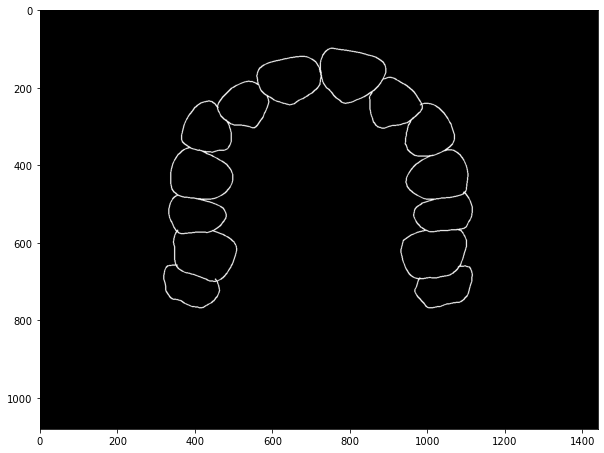

In [256]:
tic = time.time()

contour = np.zeros(edgeMask.shape, dtype=edgeMask.dtype)
# contour[pixels[:,1],pixels[:,0]] = 1.
# contour = skimage.morphology.binary_dilation(contour, skimage.morphology.disk(2))
contour = GetContourImage(contour.shape, vis_edges, 2)

toc = time.time()
print("time: {:.4f}s".format(toc-tic))
plt.figure(figsize = (10,10))
plt.imshow(contour, cmap='gray')
print("num of contour points: ", np.sum(contour>0))

In [270]:
# SIFT key point detector FOR Ground Truth Mask

# img_sk = skimage.morphology.binary_dilation(edgeMasks[0], footprint=skimage.morphology.disk(1))
img_sk = edgeMasks[0]
img_gray = (255.*img_sk).astype(np.uint8)
# sift = cv2.SIFT_create(nfeatures=500, nOctaveLayers=4, contrastThreshold=0., edgeThreshold=50, sigma=1.6)
sift = cv2.SIFT_create()
kp = sift.detect(img_gray, None)
print(len(kp))
img = cv2.drawKeypoints(img_gray, kp, img_gray)
h, w = img.shape[:2]
imS = cv2.resize(img, (2*w//3, 2*h//3)) 
cv2.imshow("output", imS)  
cv2.waitKey(0) 
cv2.destroyAllWindows()
# cv2.imwrite('sift_keypoints.jpg',img)

807


In [271]:
# SIFT key point detector

img_gray = contour
# sift = cv2.SIFT_create(nfeatures=500, nOctaveLayers=4, contrastThreshold=0., edgeThreshold=50, sigma=1.6)
sift = cv2.SIFT_create()
kp = sift.detect(img_gray, None)
print(len(kp))
img = cv2.drawKeypoints(img_gray, kp, img_gray)
cv2.imshow('image',img)
cv2.waitKey(0) 
cv2.destroyAllWindows()
# cv2.imwrite('sift_keypoints.jpg',img)

841


In [244]:
X_vis = [x[vis_hull_vid] for x,vis_hull_vid in zip(X[avg_depth.argsort()], vis_hull_vids)]
utils.showPointCloud(np.vstack(X_vis),"visible points")

## Code

In [142]:
@enum.unique
class PHOTO(enum.Enum):
    FRONTAL = 0
    UPPER = 1
    LOWER = 2
    LEFT = 3
    RIGHT = 4


class EMOpt(object):
    def __init__(self, edgeMask, photoType, Mask, Mu, SqrtEigVals, Sigma, varRotAngleXYZs, varTransVecXYZs, varScales, CovMats):        
        assert edgeMask.ndim == 2, "edgeMask should be grayscale"
        height, width = edgeMask.shape
        self.edgeMask = edgeMask # binary 2d-array
        self.P_true = np.argwhere(self.edgeMask>0)[:,::-1] # real edge point pos in image coord (u_x,v_y), 2d-array, shape=(?,2)
        self.M = len(self.P_true)
        self.P_true_normals = self.initEdgeMaskNormals()   
        print("Num of edge point in ground truth: ", self.M)
        
        # 分为上下牙列
        Mask_U, Mask_L = np.split(Mask, 2, axis=0)
        Mu_U, Mu_L = np.split(Mu, 2, axis=0)
        SqrtEigVals_U, SqrtEigVals_L = np.split(SqrtEigVals, 2, axis=0)
        Sigma_U, Sigma_L = np.split(Sigma, 2, axis=0)
        varRotAngleXYZs_U, varRotAngleXYZs_L = np.split(varRotAngleXYZs, 2, axis=0)
        varTransVecXYZs_U, varTransVecXYZs_L = np.split(varTransVecXYZs, 2, axis=0)
        varScales_U, varScales_L = np.split(varScales, 2, axis=0)
        CovMats_U, CovMats_L = np.split(CovMats, 2, axis=0)
        
        self.MuRowCenter = np.mean(np.reshape(Mu, (-1,3)), axis=0) # around [0.,0.,0.]
        
        
        self.X_Mu = Mu_U[Mask_U] # masked pointcloud ndarray, shape=(numTooth,1500,3), numTooth<=14
        self.X_Mu_centers = self.X_Mu.mean(axis=1) # shape=(numTooth,3)
        self.numTooth = self.X_Mu.shape[0]
        self.numPoint = self.X_Mu.shape[1]
        self.X_Mu_normals = self.initMuPointNormals(self.X_Mu)
        
        self.SqrtEigVals = SqrtEigVals_U[Mask_U]
        self.SigmaT = np.transpose(Sigma_U[Mask_U], (0,2,1))
        
        self.varRotAngleXYZs = varRotAngleXYZs_U[Mask_U]
        self.varTransVecXYZs = varTransVecXYZs_U[Mask_U]
        self.varScales = varScales_U[Mask_U]
        
        self.meanRotAngleXYZs = np.zeros((self.numTooth,3),dtype=np.float32) 
        self.meanTransVecXYZs = np.zeros((self.numTooth,3),dtype=np.float32) 
        self.meanScales = np.ones((self.numTooth,),dtype=np.float32) 
        
        self.invCovMats = np.linalg.inv(CovMats_U[Mask_U])
        
        self.photoType = photoType # PHOTO Enum
        
        # teeth shape subspace
        self.numPC = self.SqrtEigVals.shape[-1]
        self.featureVec = np.zeros(self.SqrtEigVals.shape, dtype=np.float32) # shape=(self.numTooth, 1, numPC), mean=0, std=1
        
        # teeth scales, rotation angles around X-Y-Z axes, translation vectors along X-Y-Z axes
        self.scales = np.ones((self.numTooth,),dtype=np.float32)
        self.rotAngleXYZs = np.zeros((self.numTooth,3),dtype=np.float32) 
        self.transVecXYZs = np.zeros((self.numTooth,3),dtype=np.float32) 

        # tooth row isotropic scale
        # self.meanRowScale = 1.
        self.varRowScale = 2.7e-3
        self.rowScale = 1.
        
        # init extrinsic param of camera
        self.ex_rxyz = self.__initExtrinsicRotAngles() # init rot angles around x-y-z axis based on photoType
        self.ex_txyz = self.__initExtrinsicTransVec(obj_dist_estimate=130.) # init trans vector
        
        # init intrinsic param of camera
        self.focLth = 105.
        self.dpix = 0.06
        self.u0 = width//2
        self.v0 = height//2
        
        self.varAngle = 0.09
        
        self.varPoint = 500.
        self.varPlane = 1000.
        self.weightTeethPose = 1.
        self.weightFeatureVec = 1.
        
        self.weightRowScale = 10.
        
        self.updateEdgePrediction()

        
    def initMuPointNormals(self, X):
        # X.shape=(self.numTooth,self.numPoint,3)
        normals = []
        for vertices in X:
            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(vertices)
            pcd.estimate_normals()
            # to obtain a consistent normal orientation
            pcd.orient_normals_consistent_tangent_plane(k=15)
            pcd.normalize_normals()
            normals.append(np.asarray(pcd.normals,dtype=np.float32))
        return np.array(normals,dtype=np.float32)
    
    def initEdgeMaskNormals(self):
        vertices_xy = self.P_true
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(np.hstack([vertices_xy, 20*np.random.rand(self.M,1)]))
        pcd.estimate_normals()
        pcd.orient_normals_consistent_tangent_plane(k=30)
        normals_xy = np.asarray(pcd.normals)[:,:2]
        pcd.normals = o3d.utility.Vector3dVector(np.hstack([normals_xy, np.zeros((self.M,1))]))
        pcd.normalize_normals()
        # o3d.visualization.draw_geometries([pcd], window_name="image edge normals estimation", width=800, height=600, left=50,top=50, point_show_normal=True)
        return np.asarray(pcd.normals, dtype=np.float32)[:,:2]

    def __initExtrinsicRotAngles(self):
        if self.photoType == PHOTO.FRONTAL:
            return np.array([0.0, np.pi, np.pi])  # frontal
        elif self.photoType == PHOTO.UPPER:
            return np.array([-0.32*np.pi, np.pi, np.pi]) # upper
        elif self.photoType == PHOTO.LOWER:
            return np.array([0.32*np.pi, np.pi, np.pi])  # lower
        elif self.photoType == PHOTO.LEFT:
            return np.array([0.0, 0.7*np.pi, np.pi]) # left
        elif self.photoType == PHOTO.RIGHT:
            return np.array([0.0, -0.7*np.pi, np.pi])  # right
        else:
            assert self.photoType in PHOTO, "photoType should be a PHOTO Enum"
    
    def __initExtrinsicTransVec(self, obj_dist_estimate=130.):
        # obj_dist_estimate: 物距 mm
        return 0., 0., -self.X_Mu[...,2].min()+obj_dist_estimate
    
    def updateDeformedPoints(self, Mu, featureVec):
        deformField = np.matmul(featureVec*self.SqrtEigVals, self.SigmaT) # shape=(self.numTooth,1,3*self.numPoint)
        return Mu + deformField.reshape(Mu.shape)
    
    
    
    
    ########################################################
    # Isotropic scaled rigid transformation for each tooth #
    ########################################################
    def computeTeethRotMats(self, rotAngleXYZs):
        batched_cosxyz = np.cos(rotAngleXYZs)
        batched_sinxyz = np.sin(rotAngleXYZs)
        vec_cx, vec_cy, vec_cz = np.split(batched_cosxyz, 3, axis=-1)
        vec_cx, vec_cy, vec_cz = np.squeeze(vec_cx,axis=-1), np.squeeze(vec_cy,axis=-1), np.squeeze(vec_cz,axis=-1)
        vec_sx, vec_sy, vec_sz = np.split(batched_sinxyz, 3, axis=-1)
        vec_sx, vec_sy, vec_sz = np.squeeze(vec_sx,axis=-1), np.squeeze(vec_sy,axis=-1), np.squeeze(vec_sz,axis=-1)
        vec_1 = np.ones_like(vec_cx)
        vec_0 = np.zeros_like(vec_cx)

        rotMatXs = np.stack([vec_1,vec_0,vec_0, vec_0,vec_cx,vec_sx, vec_0,-vec_sx,vec_cx], axis=-1)
        rotMatXs = np.reshape(rotMatXs, (self.numTooth,3,3))
        rotMatYs = np.stack([vec_cy,vec_0,-vec_sy, vec_0,vec_1,vec_0, vec_sy,vec_0,vec_cy], axis=-1)
        rotMatYs = np.reshape(rotMatYs, (self.numTooth,3,3))
        rotMatZs = np.stack([vec_cz,vec_sz,vec_0, -vec_sz,vec_cz,vec_0, vec_0,vec_0,vec_1], axis=-1)
        rotMatZs = np.reshape(rotMatZs, (self.numTooth,3,3))

        rotMats = np.matmul(rotMatXs, rotMatYs)
        rotMats = np.matmul(rotMats, rotMatZs)
        return rotMats
    
    def updateTransformedPointPos(self, X_deformed, scales, rotMats, transVecXYZs):
        return np.multiply(scales[:,None,None], np.matmul(X_deformed+transVecXYZs[:,None,:], rotMats))
    
    def updateTransformedPointNormals(self, X_deformed_normals, rotMats):
        return np.matmul(X_deformed_normals, rotMats)
    
    
    
    
    ###############################
    # world coord -> camera coord #
    ###############################
    def updateExtrinsicViewMatrix(self, ex_rxyz, ex_txyz): # world coord to camera coord
        # 先进行x轴旋转，再y轴，再z轴；取转置表示右乘旋转矩阵，再平移
        # R = o3d.geometry.get_rotation_matrix_from_zyx(ex_rxyz[::-1]).T
        cx, cy, cz = np.cos(ex_rxyz)
        sx, sy, sz = np.sin(ex_rxyz)
        rotMatX = np.array([[1.,0.,0.],[0.,cx,sx],[0.,-sx,cx]])
        rotMatY = np.array([[cy,0.,-sy],[0.,1.,0.],[sy,0.,cy]])
        rotMatZ = np.array([[cz,sz,0.],[-sz,cz,0.],[0.,0.,1.]])
        R = rotMatX @ rotMatY @ rotMatZ
        return np.vstack([R, ex_txyz]) # Matrix 4*3
    
    
    # def updatePointPosInCameraCoord(self, X_world, extrViewMat):
    #     # get 3D point cloud in camera coord, return array shape (n,3) or (batch,n,3)
    #     X_homo = np.concatenate([X_world, np.ones((*X_world.shape[:-1],1))], axis=-1)
    #     return np.matmul(X_homo, extrViewMat)
        
    def updatePointPosInCameraCoord(self, X_world, extrViewMat, rowScale):
        # get 3D point cloud in camera coord, return array shape (n,3) or (batch,n,3)
        R_ex = extrViewMat[:3,:]
        T_ex = extrViewMat[3,:]
        T_sca = (self.X_Mu_centers-self.MuRowCenter) * (rowScale-1.) @ R_ex
        return np.matmul(X_world, R_ex) + T_ex[None,None,:] + T_sca[:,None,:]
    
    def updatePointNormalsInCameraCoord(self, X_world_normals, extrViewRotMat):
        return np.matmul(X_world_normals, extrViewRotMat)
    
    
    
    
    ##############################
    # camera coord ->image coord #
    ##############################
    
    def updateIntrinsicProjectionMatrix(self, focLth, dpix, u0, v0): # camera cood to image coord
        mat1 = np.diag([focLth, focLth, 1.])
        mat2 = np.array([[1./dpix, 0., 0.], [0., 1./dpix, 0.], [u0, v0, 1.]])
        return mat1 @ mat2 # Matrix 3*3

    def updatePointPosInImageCoord(self, X_camera, intrProjMat):
        # get 3D point cloud in image coord, return array shape (n,2) or (batch,n,2)
        assert (X_camera[...,2]>0).all() # Z-value of points should be positive
        X_image = np.matmul((X_camera/X_camera[...,[2]]), intrProjMat)
        X_uv = X_image[...,:2]
        return np.around(X_uv).astype(np.int32)
    
    def updatePointNormalsInImageCoord(self, X_camera_normals):
        X_cam_normals_xy = X_camera_normals[:,:,:2]
        return X_cam_normals_xy / np.linalg.norm(X_cam_normals_xy, axis=2, keepdims=True)
    
    
    
    
    
    ##################################################
    # Extract contour pixels in projected pointcloud #
    ##################################################
    
    def __getUniquePixels(self, X_uv_int):
        # merge points at the same position in image coord
        # X_uv_int: array shape (n,2)dtype np.int32
        # pixels: array (m,2), each element represents (u_x, v_y)
        pixels, unique_indices = np.unique(X_uv_int,axis=0,return_index=True)
        return pixels, unique_indices
    
    def __getConcaveHullEdgeVertexIndices(self, coords, alpha):  # coords is a 2D numpy array (u_x,v_y)
        tri = Delaunay(coords, qhull_options="Qt Qc Qz Q12").simplices
        ia, ib, ic = (tri[:, 0], tri[:, 1], tri[:, 2])  # indices of each of the triangles' points
        pa, pb, pc = (coords[ia], coords[ib], coords[ic])  # coordinates of each of the triangles' points
        a = np.linalg.norm(pa-pb, ord=2, axis=1)
        b = np.linalg.norm(pb-pc, ord=2, axis=1)
        c = np.linalg.norm(pc-pa, ord=2, axis=1)
        s = (a + b + c) * 0.5  # Semi-perimeter of triangle
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))  # Area of triangle by Heron's formula
        filter = (a * b * c / (4.0 * area) < 1.0 / alpha)  # Radius Filter based on alpha value
        edges = tri[filter]
        edges = [tuple(sorted(combo)) for e in edges for combo in itertools.combinations(e, 2)]
        count = Counter(edges)  # count occurrences of each edge
        edge_indices = [e for e, c in count.items() if c == 1]
        return np.array(edge_indices)
    
    def __constructConcaveHull(self, coords, edge_indices): # coords is a 2D numpy array (u_x,v_y)
        edges = [(coords[e[0]], coords[e[1]]) for e in edge_indices]
        ml = MultiLineString(edges)
        poly = polygonize(ml)
        hull = unary_union(list(poly))
        return hull
    
    def extractVisibleEdgePointsByAvgDepth(self):
        # X_uv: shape=(batch,n,2), dtype=np.int32
        # avg_depth: array shape (batch,)
        avg_depth = self.X_camera[...,2].mean(axis=1)
        tooth_order = avg_depth.argsort()
        X_uv_sort = self.X_uv[tooth_order]
        hulls = []
        vis_hull_vs = []
        vis_hull_vids = []
        for x_uv in X_uv_sort:
            pixels, pixel_xuv_map = self.__getUniquePixels(x_uv)
            edge_v_indices = self.__getConcaveHullEdgeVertexIndices(pixels, alpha=0.05)
            hull = self.__constructConcaveHull(pixels, edge_v_indices)
            uni_edge_v_indices = np.unique(edge_v_indices)
            hull_v = x_uv[pixel_xuv_map[uni_edge_v_indices]]
            flags = np.ones((len(hull_v),),dtype=np.bool_)
            for i,v in enumerate(hull_v):
                for exist_hull in hulls:
                    if exist_hull.contains(Point(v)):
                        flags[i] = False
                        break
            if flags.any()==True:
                hulls.append(hull)
                vis_hull_vs.append(hull_v[flags]) # 可见点
                vis_hull_vids.append(pixel_xuv_map[uni_edge_v_indices[flags]])
        # sort in the init order
        vis_hull_vs = [x for _, x in sorted(zip(tooth_order, vis_hull_vs), key=lambda pair: pair[0])]
        vis_hull_vids = [x for _, x in sorted(zip(tooth_order, vis_hull_vids), key=lambda pair: pair[0])]
        return vis_hull_vs, vis_hull_vids
    
    
    
    
    
    
    def expectation_step(self, verbose=True):
        self.updateEdgePrediction()
        self.point_loss_mat = distance_matrix(self.P_true, self.P_pred, p=2, threshold=int(1e8))**2
        # print(self.P_true_normals.shape)
        self.normal_loss_mat = - (self.P_true_normals @ self.P_pred_normals.T)**2 / self.varAngle
        self.loss_mat = self.point_loss_mat * np.exp(self.normal_loss_mat)
        self.corre_pred_idx = np.argmin(self.loss_mat, axis=1)
        losses = self.loss_mat[np.arange(self.M), self.corre_pred_idx]
        self.loss_expectation_step = np.sum(losses)
        if verbose==True:
            print("num of corre pred unique point: {}".format(len(np.unique(self.corre_pred_idx))))
            print("sum of loss in expectation step: {:.2f}".format(self.loss_expectation_step))

        
    def computePixelResidualError(self, featureVec, scales, rotAngleXYZs, transVecXYZs, rowScale, extrViewMat, intrProjMat, stage=1):
        # self.X_?_pred: List of array of points in Mu teeth shape, [ndarray1, ndarray2, ...]
        # self.corre_pred_idx: corre indices after vertically stacking the transformed self.X_?_pred
        X_deformed_pred = self.X_Mu_pred
        X_trans_pred = self.X_Mu_pred
        X_deformed_pred_normals = self.X_Mu_pred_normals
        X_trans_pred_normals = self.X_Mu_pred_normals
        if stage >= 3:
            X_deformed_pred = [x_mu_pred+np.reshape(sqrtEigVal*fVec@sigmaTseg,x_mu_pred.shape) for x_mu_pred,sqrtEigVal,fVec,sigmaTseg in \
                              zip(self.X_Mu_pred, self.SqrtEigVals, featureVec, self.SigmaT_segs)] # 轮廓点对应原始点云进行Shape subspace变形操作
            # X_deformed_pred_normals = ??
        if stage >= 2:
            rotMats = self.computeTeethRotMats(rotAngleXYZs)
            X_trans_pred = [s*np.matmul(x+t,R) for x,s,R,t in zip(X_deformed_pred, scales, rotMats, transVecXYZs)] # 轮廓点对应原始点云按牙齿分别进行缩放刚性变换
            X_trans_pred_normals = [np.matmul(xn,R) for xn,R in zip(X_deformed_pred_normals, rotMats)]
            
#         X_corre_pred = np.vstack(X_trans_pred)[self.corre_pred_idx]
        X_corre_pred_normals = np.vstack(X_trans_pred_normals)[self.corre_pred_idx]
        
#         X_cam_corre_pred = self.updatePointPosInCameraCoord(X_corre_pred, extrViewMat) #相机坐标系下对应点坐标
        X_cam_corre_pred_normals = X_corre_pred_normals @ extrViewMat[:3,:] # extrViewMat.shape = (4,3)
        
        R_ex = extrViewMat[:3,:]
        T_ex = extrViewMat[[3],:]
        T_sca = (self.X_Mu_centers-self.MuRowCenter) * (rowScale-1.) @ R_ex
        X_cam_pred = [np.matmul(x,R_ex)+T_ex+t_sca for x,t_sca in zip(X_trans_pred, T_sca)]
        X_cam_corre_pred = np.vstack(X_cam_pred)[self.corre_pred_idx]
        
        P_corre_pred = self.updatePointPosInImageCoord(X_cam_corre_pred, intrProjMat)
        P_corre_pred_normals = X_cam_corre_pred_normals[:,:2] # 取相机坐标系下normals的x,y坐标即为图片坐标系中的normals
        P_corre_pred_normals = P_corre_pred_normals / np.linalg.norm(P_corre_pred_normals, axis=1, keepdims=True) #单位化normals \hat{ni}
        
        errorVecUV = self.P_true - P_corre_pred # ci - \hat{ci}
        resPointError = np.linalg.norm(errorVecUV, axis=1)**2
        resPlaneError = np.sum(errorVecUV*P_corre_pred_normals, axis=1)**2
        

        return np.sum(resPointError)/self.varPoint + np.sum(resPlaneError)/self.varPlane
    
    def residualErrorOfExtrinsicParams(self, extrParams):
        # extrParams = np.array([ex_rx, ex_ry, ex_rz, ex_tx, ex_ty, ex_tz])
        # ex_rxyz, ex_txyz = np.split(extrParams, 2)
        rowScale = extrParams[0]
        ex_rxyz, ex_txyz = np.split(extrParams[1:], 2)
        extrViewMat = self.updateExtrinsicViewMatrix(ex_rxyz, ex_txyz)
        errorPixel = self.computePixelResidualError(self.featureVec, self.scales, self.rotAngleXYZs, self.transVecXYZs, rowScale, extrViewMat, self.intrProjMat, stage=1)
        errorRowScale = self.weightRowScale * (rowScale - 1.)**2 / self.varRowScale
        return errorPixel + errorRowScale
    
    def residualErrorOfIntrinsicParams(self, intrParams):
        # intrParams = [focLth, dpix, u0, v0]
        focLth, dpix, u0, v0 = intrParams
        intrProjMat = self.updateIntrinsicProjectionMatrix(focLth, dpix, u0, v0)
        return self.computePixelResidualError(self.featureVec, self.scales, self.rotAngleXYZs, self.transVecXYZs, self.rowScale, self.extrViewMat, intrProjMat, stage=1)

    
    def residualErrorOfTeethPose(self, teethPoseParams, printFlag):
        # teethPoseParams = np.array([scales, transVecXYZs.flatten(), rotAngleXYZs.flatten()])
        scales = teethPoseParams[:self.numTooth]
        transVecXYZs, rotAngleXYZs = np.split(teethPoseParams[self.numTooth:], 2)
        rotAngleXYZs = rotAngleXYZs.reshape(self.numTooth, 3)
        transVecXYZs = transVecXYZs.reshape(self.numTooth, 3)
        errorPixel = self.computePixelResidualError(self.featureVec, scales, rotAngleXYZs, transVecXYZs, self.rowScale, self.extrViewMat, self.intrProjMat, stage=2) # negative log likelihood of pixel distance distribution

        # errorTeethPoseParam = self.weightTeethPose * (np.sum((scales-self.meanScales)**2 / self.varScales) + \
        #                     np.sum((rotAngleXYZs-self.meanRotAngleXYZs)**2 / self.varRotAngleXYZs) + \
        #                     np.sum((transVecXYZs-self.transVecXYZs)**2 / self.varTransVecXYZs))
        
        centeredPoseParams = np.hstack([(scales-self.meanScales)[:,None], (transVecXYZs-self.meanTransVecXYZs), (rotAngleXYZs-self.meanRotAngleXYZs)]) # shape=(self.numTooth,7)
        errorTeethPoseParam = self.weightTeethPose * np.sum(np.matmul(np.matmul(centeredPoseParams[:,None,:], self.invCovMats), centeredPoseParams[:,:,None]))
        if printFlag == True:
            print("errorPixel:{:.2f}, errorTeethPoseParam:{:.2f}".format(errorPixel, errorTeethPoseParam))
        return errorPixel + errorTeethPoseParam
    
    def residualErrorOfTeethScales(self, scales, printFlag):
        errorPixel = self.computePixelResidualError(self.featureVec, scales, self.rotAngleXYZs, self.transVecXYZs, self.rowScale, self.extrViewMat, self.intrProjMat, stage=2) # negative log likelihood of pixel distance distribution
        centeredPoseParams = np.hstack([(scales-self.meanScales)[:,None], (self.transVecXYZs-self.meanTransVecXYZs), (self.rotAngleXYZs-self.meanRotAngleXYZs)]) # shape=(self.numTooth,7)
        errorTeethPoseParam = self.weightTeethPose * np.sum(np.matmul(np.matmul(centeredPoseParams[:,None,:], self.invCovMats), centeredPoseParams[:,:,None]))
        if printFlag == True:
            print("errorPixel:{:.2f}, errorTeethPoseParam:{:.2f}".format(errorPixel, errorTeethPoseParam))
        return errorPixel + errorTeethPoseParam
    
#     def residualErrorOfTeethRotAngleXYZs(self, rotAngleXYZs_flat, printFlag):
#         rotAngleXYZs = rotAngleXYZs_flat.reshape(self.numTooth, 3)
#         errorPixel = self.computePixelResidualError(self.featureVec, self.scales, rotAngleXYZs, self.transVecXYZs, self.rowScale, self.extrViewMat, self.intrProjMat, stage=2) # negative log likelihood of pixel distance distribution
#         centeredPoseParams = np.hstack([(self.scales-self.meanScales)[:,None], (self.transVecXYZs-self.meanTransVecXYZs), (rotAngleXYZs-self.meanRotAngleXYZs)]) # shape=(self.numTooth,7)
#         errorTeethPoseParam = self.weightTeethPose * np.sum(np.matmul(np.matmul(centeredPoseParams[:,None,:], self.invCovMats), centeredPoseParams[:,:,None]))
#         if printFlag == True:
#             print("errorPixel:{:.2f}, errorTeethPoseParam:{:.2f}".format(errorPixel, errorTeethPoseParam))
#         return errorPixel + errorTeethPoseParam
    
    def residualErrorOfTeethTransVecXYZs(self, transVecXYZs_flat, printFlag):
        transVecXYZs = transVecXYZs_flat.reshape(self.numTooth, 3)
        errorPixel = self.computePixelResidualError(self.featureVec, self.scales, self.rotAngleXYZs, transVecXYZs, self.rowScale, self.extrViewMat, self.intrProjMat, stage=2) # negative log likelihood of pixel distance distribution
        centeredPoseParams = np.hstack([(self.scales-self.meanScales)[:,None], (transVecXYZs-self.meanTransVecXYZs), (self.rotAngleXYZs-self.meanRotAngleXYZs)]) # shape=(self.numTooth,7)
        errorTeethPoseParam = self.weightTeethPose * np.sum(np.matmul(np.matmul(centeredPoseParams[:,None,:], self.invCovMats), centeredPoseParams[:,:,None]))
        if printFlag == True:
            print("errorPixel:{:.2f}, errorTeethPoseParam:{:.2f}".format(errorPixel, errorTeethPoseParam))
        return errorPixel + errorTeethPoseParam
    
    def residualErrorOfFeatureVec(self, featureVecParam, printFlag):
        featureVec = featureVecParam.reshape((self.numTooth,1,self.numPC))
        errorPixel = self.computePixelResidualError(featureVec, self.scales, self.rotAngleXYZs, self.transVecXYZs, self.rowScale, self.extrViewMat, self.intrProjMat, stage=3)
        errorFeatureVec = self.weightFeatureVec * np.sum(featureVec**2)
        if printFlag == True:
            print("errorPixel:{:.2f}, errorFeatureVec:{:.2f}".format(errorPixel, errorFeatureVec))
        return errorPixel + errorFeatureVec
        
    def maximization_stage1_step(self):
        # resOptExtrParams = scipy.optimize.minimize(fun=self.residualErrorOfExtrinsicParams, x0=np.hstack([self.ex_rxyz,self.ex_txyz]), method="Nelder-Mead")
        resOptExtrParams = scipy.optimize.minimize(fun=self.residualErrorOfExtrinsicParams, x0=np.hstack([self.rowScale, self.ex_rxyz,self.ex_txyz]), method="Nelder-Mead")
        # print(resOptExtrParams.x)
        self.rowScale = resOptExtrParams.x[0]
        self.ex_rxyz, self.ex_txyz = np.split(resOptExtrParams.x[1:], 2)
        resOptIntrParams = scipy.optimize.minimize(fun=self.residualErrorOfIntrinsicParams, x0=[self.focLth, self.dpix, self.u0, self.v0], method="Nelder-Mead")
        # print(resOptIntrParams.x)
        self.focLth, self.dpix, self.u0, self.v0 = resOptIntrParams.x

        
    def maximization_stage2_step(self):
        # x = np.hstack([self.scales, self.transVecXYZs.flatten(), self.rotAngleXYZs.flatten()])
        # resOptTeethPoseParams = scipy.optimize.minimize(fun=self.residualErrorOfTeethPose, x0=x, args=(False,), method="COBYLA", options={"rhobeg":0.005,"maxiter":500})
        # self.scales = resOptTeethPoseParams.x[:self.numTooth]
        # transVecXYZs_flat, rotAngleXYZs_flat = np.split(resOptTeethPoseParams.x[self.numTooth:], 2)
        # self.rotAngleXYZs = np.reshape(rotAngleXYZs_flat,(self.numTooth,3))
        # self.transVecXYZs = np.reshape(transVecXYZs_flat,(self.numTooth,3))
        
        resScales = scipy.optimize.minimize(fun=self.residualErrorOfTeethScales, x0=self.scales, args=(False,), method="COBYLA", options={"rhobeg":0.005,"maxiter":500})
        self.scales = resScales.x
        
#         resRotAngleXYZs_flat = scipy.optimize.minimize(fun=self.residualErrorOfTeethRotAngleXYZs, x0=self.rotAngleXYZs.flatten(), args=(False,), method="COBYLA", options={"rhobeg":0.005,"maxiter":500})
#         self.rotAngleXYZs = resRotAngleXYZs_flat.x.reshape(self.numTooth,3)
        
        resTransVecXYZs_flat = scipy.optimize.minimize(fun=self.residualErrorOfTeethTransVecXYZs, x0=self.transVecXYZs.flatten(), args=(False,), method="COBYLA", options={"rhobeg":0.5,"maxiter":500})
        self.transVecXYZs = resTransVecXYZs_flat.x.reshape(self.numTooth,3)
        
        x = np.hstack([self.scales, self.transVecXYZs.flatten(), self.rotAngleXYZs.flatten()])
        self.residualErrorOfTeethPose(x, True)
        
        
    def updateCorreSigmaTSegs(self):
        SigmaT_segs = []
        for sigmaT,vis_hull_vids in zip(self.SigmaT, self.vis_hull_vertex_indices):
            sigmaTseg = sigmaT.reshape(self.numPC, self.numPoint, 3)[:,vis_hull_vids,:]
            SigmaT_segs.append(sigmaTseg.reshape(self.numPC, 3*len(vis_hull_vids)))
        return SigmaT_segs
            
    def maximization_stage3_step(self):
        self.SigmaT_segs = self.updateCorreSigmaTSegs()
        resOptFeatureVec = scipy.optimize.minimize(fun=self.residualErrorOfFeatureVec, x0=self.featureVec.flatten(), args=(False,), method="COBYLA", options={"rhobeg":0.1})
        self.featureVec = np.reshape(resOptFeatureVec.x, self.featureVec.shape)
        self.residualErrorOfFeatureVec(self.featureVec.flatten(), True)

        
    
    def updateEdgePrediction(self):
        self.X_deformed = self.updateDeformedPoints(self.X_Mu, self.featureVec)
        # X_deformed_normals = ??
        
        self.RotMats = self.computeTeethRotMats(self.rotAngleXYZs)
        self.X_trans = self.updateTransformedPointPos(self.X_deformed, self.scales, self.RotMats, self.transVecXYZs)
        self.X_trans_normals = self.updateTransformedPointNormals(self.X_Mu_normals, self.RotMats)
        
        self.extrViewMat = self.updateExtrinsicViewMatrix(self.ex_rxyz, self.ex_txyz) # homo world coord (xw,yw,zw,1) to camera coord (xc,yc,zc): 4*3 right-multiplying matrix
        self.X_camera = self.updatePointPosInCameraCoord(self.X_trans, self.extrViewMat, self.rowScale) # compute X in camera coord based on X in world coord, ndarray, shape=(numTooth,1500,3)
        self.X_camera_normals = self.updatePointNormalsInCameraCoord(self.X_trans_normals, self.extrViewMat[:3,:])
        
        self.intrProjMat = self.updateIntrinsicProjectionMatrix(self.focLth, self.dpix, self.u0, self.v0) # camera coord (xc,yc,zc) to image coord (u,v,zc): 3*3 right-multiplying matrix
        self.X_uv = self.updatePointPosInImageCoord(self.X_camera, self.intrProjMat) # compute X in image coord based on X_camera in camera coord, ndarray, shape=(numTooth,1500,2)
        self.X_uv_normals = self.updatePointNormalsInImageCoord(self.X_camera_normals)
        
        self.vis_hull_vertices, self.vis_hull_vertex_indices = self.extractVisibleEdgePointsByAvgDepth() # visible points in image coord, and corre idx in X
        self.P_pred = np.vstack(self.vis_hull_vertices) # edgeMask prediction 2d-array, shape=(?,2)
        self.P_pred_normals = np.vstack([x[vis_hull_vids] for x,vis_hull_vids in zip(self.X_uv_normals, self.vis_hull_vertex_indices)])  # edgeMask normals prediction 2d-array, shape=(?,2)
        
        self.X_Mu_pred = [x[vis_hull_vids] for x,vis_hull_vids in zip(self.X_Mu, self.vis_hull_vertex_indices)] # points in world coord corre to edgeMask prediction
        self.X_Mu_pred_normals = [x[vis_hull_vids] for x,vis_hull_vids in zip(self.X_Mu_normals, self.vis_hull_vertex_indices)]

    
    def showEdgeMaskPrediction(self, canvasShape=None):
        if not bool(canvasShape):
            canvasShape = self.edgeMask.shape
        contour = np.zeros(canvasShape, dtype=np.float32)
        contour[self.P_pred[:,1], self.P_pred[:,0]] = 1.
        plt.figure(figsize = (10,10))
        plt.imshow(contour, cmap='gray')
    def showEdgeMaskGroundTruth(self, canvasShape=None):
        plt.figure(figsize = (10,10))
        if bool(canvasShape):
            contour = np.zeros(canvasShape, dtype=np.float32)
            h,w = self.edgeMask.shape
            contour[:h,:w] = self.edgeMask
            plt.imshow(contour, cmap='gray')
        else:
            plt.imshow(self.edgeMask, cmap='gray')
    def showEdgeMaskPredictionWithGroundTruth(self, canvasShape=None):
        if not bool(canvasShape):
            canvasShape = self.edgeMask.shape
        canvas = np.zeros((*canvasShape,3), dtype=np.float32)
        h, w = self.edgeMask.shape
        canvas[:h,:w,:] = self.edgeMask[:,:,None] # white: ground truth
        
        edgePred = np.zeros(canvasShape, dtype=np.float32)
        edgePred[self.P_pred[:,1], self.P_pred[:,0]] = 1. # red: edge prediction
        edgePred = skimage.morphology.binary_dilation(edgePred, skimage.morphology.disk(2)) # dilation edge prediction for visualization
        canvas[:,:,0] = np.max(np.stack([edgePred,canvas[:,:,0]]), axis=0)
        
        plt.figure(figsize = (10,10))
        plt.imshow(canvas)

In [143]:
def computeMeanL2Error(X_esti, X_Ref, shiftVec):
    X_esti = X_esti + shiftVec
    pointL2Errors = np.linalg.norm(X_esti - X_Ref, axis=2, ord=2)
    return np.mean(pointL2Errors)

In [144]:
invRotAngleXYZVars = invRotAngleXYZVars.reshape(-1,3)
invTransVecXYZVars = invTransVecXYZVars.reshape(-1,3)
emopt = EMOpt(edgeMasks[0], PHOTO.UPPER, Mask, Mu, SqrtEigVals, Sigma, invRotAngleXYZVars, invTransVecXYZVars, invScaleVars, CovMats)

# ground truth initialization
# emopt.ex_rxyz = np.array([-0.9955111,   3.17611472,  3.16857236])
# emopt.ex_txyz = np.array([8.87329606e-04, 5.81704248e-05, 1.49022813e+02])
# emopt.focLth = 114.45680761036081
# emopt.dpix = 0.062036200687782914
# emopt.rowScale = 0.95
# emopt.updateEdgePrediction()

# emopt = EMOpt(edgeMasks[4], PHOTO.FRONTAL, Mask, Mu, SqrtEigVals, Sigma, invRotAngleXYZVars, invTransVecXYZVars, invScaleVars, CovMats)

# emopt = EMOpt(edgeMasks[0], PHOTO.UPPER, Mask, PG_Ref, SqrtEigVals, Sigma, invRotAngleXYZVars, invTransVecXYZVars, invScaleVars, CovMats)

print("real mean L2 error(mm): {:.4f}".format(computeMeanL2Error(emopt.X_trans, X_Ref_U, SHIFT_VEC)))
canvasShape = (720,960)

Num of edge point in ground truth:  4914
real mean L2 error(mm): 2.4639


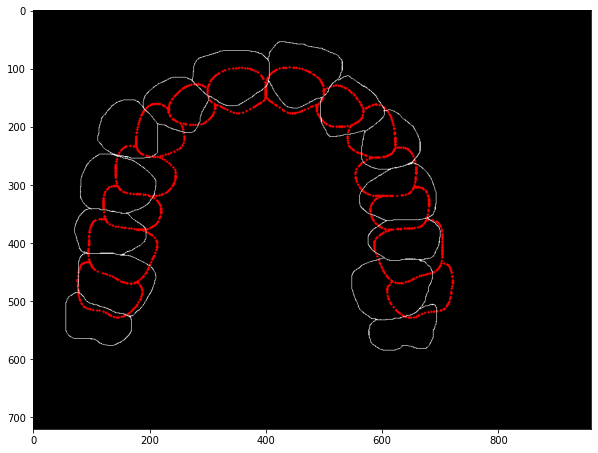

In [145]:
emopt.showEdgeMaskPredictionWithGroundTruth(canvasShape)

In [146]:
for _ in range(10):
    emopt.expectation_step(verbose=True)
    emopt.maximization_stage1_step()

num of corre pred unique point: 625
sum of loss in expectation step: 101.91
num of corre pred unique point: 627
sum of loss in expectation step: 81.05
num of corre pred unique point: 747
sum of loss in expectation step: 85.49
num of corre pred unique point: 803
sum of loss in expectation step: 50.78
num of corre pred unique point: 762
sum of loss in expectation step: 47.45
num of corre pred unique point: 743
sum of loss in expectation step: 46.36
num of corre pred unique point: 748
sum of loss in expectation step: 46.31
num of corre pred unique point: 748
sum of loss in expectation step: 46.37
num of corre pred unique point: 771
sum of loss in expectation step: 45.79
num of corre pred unique point: 772
sum of loss in expectation step: 45.94


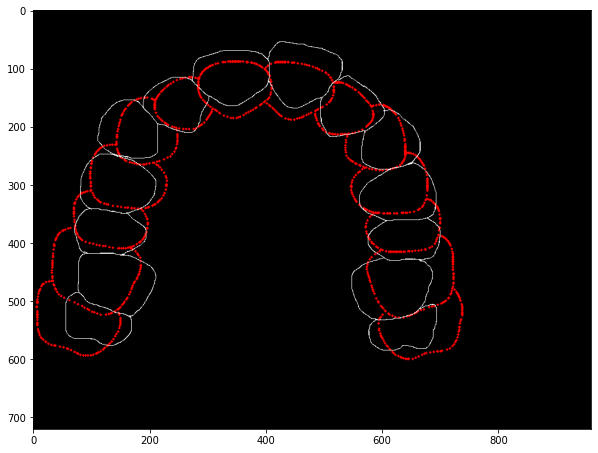

In [135]:
emopt.showEdgeMaskPredictionWithGroundTruth(canvasShape)

In [136]:
print("row scale: ", emopt.rowScale)
print("ex_rxyz: ", emopt.ex_rxyz)
print("ex_txyz: ", emopt.ex_txyz)
print("focal length: ", emopt.focLth)
print("d_pixel: ", emopt.dpix)
print("u0: {}, v0: {}".format(emopt.u0, emopt.v0))

row scale:  0.8624311638054396
ex_rxyz:  [-1.11396567  3.20976348  3.16048   ]
ex_txyz:  [-2.53132779e-07  1.21110703e-04  1.39777523e+02]
focal length:  120.71826688295297
d_pixel:  0.061420112555883755
u0: 389.2037410660332, v0: 311.4663229924923


In [137]:
for _ in range(5):
    emopt.expectation_step(verbose=True)
    emopt.maximization_stage2_step()
    print("real mean L2 error(mm): {:.4f}".format(computeMeanL2Error(emopt.X_trans, X_Ref_U, SHIFT_VEC)))

num of corre pred unique point: 757
sum of loss in expectation step: 45.44
errorPixel:3619.74, errorTeethPoseParam:126.27
real mean L2 error(mm): 2.4639
num of corre pred unique point: 833
sum of loss in expectation step: 19.76
errorPixel:2601.18, errorTeethPoseParam:152.59
real mean L2 error(mm): 2.2961
num of corre pred unique point: 856
sum of loss in expectation step: 17.90
errorPixel:2486.04, errorTeethPoseParam:157.07
real mean L2 error(mm): 2.2121
num of corre pred unique point: 878
sum of loss in expectation step: 17.62
errorPixel:2456.84, errorTeethPoseParam:150.22
real mean L2 error(mm): 2.1568
num of corre pred unique point: 868
sum of loss in expectation step: 17.56
errorPixel:2458.80, errorTeethPoseParam:154.81
real mean L2 error(mm): 2.1413


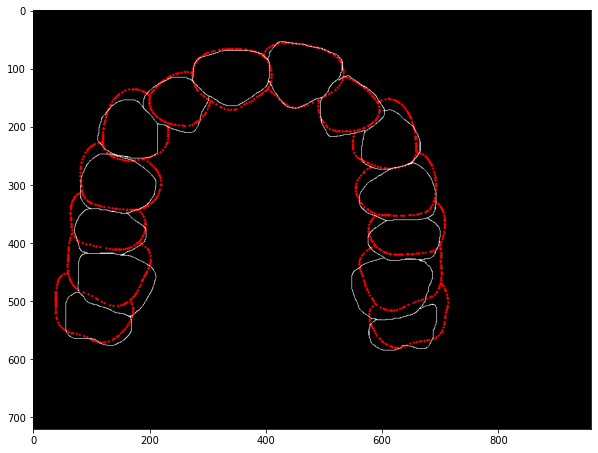

In [138]:
emopt.showEdgeMaskPredictionWithGroundTruth(canvasShape)

In [395]:
for _ in range(1):
    emopt.expectation_step(verbose=True)
    emopt.maximization_stage3_step()
    print("real mean L2 error(mm): {:.4f}".format(computeMeanL2Error(emopt.X_trans, X_Ref_U, SHIFT_VEC)))

num of corre pred unique point: 1009
sum of loss in expectation step: 5.57
errorPixel:626.80, errorFeatureVec:0.51
real mean L2 error(mm): 1.3228


In [ ]:
emopt.showEdgeMaskPredictionWithGroundTruth(canvasShape)

In [139]:
(emopt.transVecXYZs - emopt.meanTransVecXYZs) / np.sqrt(emopt.varTransVecXYZs)

array([[-0.0183174 ,  0.00624072,  0.10001971],
       [-0.0470468 , -0.0079269 ,  0.03388909],
       [-0.07299049,  0.01751593,  0.02110698],
       [ 0.01586435, -0.04727953, -0.01531051],
       [ 0.02082056, -0.02281516, -0.00517685],
       [ 0.01344359, -0.03534309,  0.00179087],
       [ 0.03267634, -0.00927521,  0.02033218],
       [-0.00569327, -0.00291952,  0.1334483 ],
       [ 0.02187026, -0.01508143,  0.0050335 ],
       [ 0.06700508,  0.00774718,  0.00225675],
       [-0.05581264, -0.00545258, -0.05580824],
       [-0.04696345, -0.02080704, -0.01844994],
       [-0.04468549, -0.02531894,  0.0005224 ],
       [-0.02683537, -0.00445775, -0.00512765]])

In [98]:
(emopt.rotAngleXYZs - emopt.meanRotAngleXYZs) / np.sqrt(emopt.varRotAngleXYZs)

array([[-8.27760790e-02,  1.08252716e-04, -5.42879570e-02],
       [ 1.27015772e-01, -1.52279871e-01,  1.02459258e-01],
       [-4.79475109e-02, -9.88220014e-02,  5.15355428e-02],
       [ 3.27649303e-01, -2.81707003e-01,  1.03464007e-01],
       [ 8.25826763e-02, -3.16194793e-01,  4.02712043e-01],
       [-4.99323801e-02, -8.63475133e-01,  3.23481388e-02],
       [ 1.74371427e-01, -4.18686437e-01, -3.89090534e-02],
       [-1.37416691e-01, -1.01915109e-02,  1.87196838e-01],
       [ 7.14428334e-02,  1.04497127e-01,  5.54014199e-02],
       [ 1.75199300e-01,  1.77124153e-01,  5.50534142e-02],
       [ 1.45939968e-01,  3.04890012e-01, -1.39696396e-01],
       [-6.88117796e-02,  2.34296549e-01, -5.78501439e-02],
       [-1.96031608e-02,  9.68414693e-01,  1.96144886e-01],
       [ 1.96238581e-01,  5.29656437e-01,  1.99439839e-01]])

In [140]:
def showPredPointClouds(y,py):
    pcdY = o3d.geometry.PointCloud()
    pcdY.points = o3d.utility.Vector3dVector(y)
    pcdY.paint_uniform_color(np.array([1.,0.,0.]))
    pcdPY = o3d.geometry.PointCloud()
    pcdPY.points = o3d.utility.Vector3dVector(py)
    pcdPY.paint_uniform_color(np.array([0.,0.,1.]))
    o3d.visualization.draw_geometries([pcdY,pcdPY], window_name="Ground Truth PCL(red) and Prediction PCL(blue)", width=800, height=600, left=50,top=50, point_show_normal=False)

In [141]:
showPredPointClouds(y=X_Ref_U.reshape(-1,3),py=(emopt.X_trans+SHIFT_VEC).reshape(-1,3))